In [42]:
# The version with separate transforms and some other changes.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable


In [43]:
TRAIN_DIR = r"C:\Users\Sumeer\Downloads\LULC\train"
VALID_DIR = r"C:\Users\Sumeer\Downloads\LULC\valid"
TEST_DIR = r"C:\Users\Sumeer\Downloads\LULC\test"
COLOR_CODES = r"C:\Users\Sumeer\Downloads\LULC\class_dict.csv"

# Transformation for images (including resizing and converting to tensor)
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # this works fine for images
])

# Transformation for masks (using nearest neighbor interpolation for resize)
mask_transform = transforms.Compose([
    transforms.ToTensor(),  # ensure mask remains a tensor with integer values
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)  # use nearest neighbor for masks
])

In [44]:
df = pd.read_csv(COLOR_CODES)
label_map = {}
for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
label_map

# label_map = {
#     0: [0, 255, 255],  # class1
#     1: [255, 255, 0],  # class2
#     2: [255, 0, 255],  # class3
#     3: [0, 255, 0],    # class4
#     4: [0, 0, 255],    # class5
#     5: [255, 255, 255],# class6
#     6: [0, 0, 0]       # class7
# }
# label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [45]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg')])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png')])
        
        # Debug prints
        print(f'Number of images: {len(self.images_name)}')
        print(f'Number of masks: {len(self.targets_name)}')

    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        if idx >= len(self.images_name) or idx >= len(self.targets_name):
            raise IndexError(f'Index {idx} out of range. Lengths are {len(self.images_name)} for images and {len(self.targets_name)} for masks.')
        
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.int64)  # Ensure mask is in int64 for class indices

In [31]:
# TESTING - seems to be working fine
mask_path =r'C:\Users\Sumeer\Downloads\LULC\train\27460_mask.png'
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# Flatten the mask and get unique colors
unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

# Check if each color is in the label_map
for color in unique_colors:
    if not any(np.array_equal(color, np.array(c)) for c in label_map.values()):
        print(f"Color {color} is not in the label_map")

In [32]:
"""img, mask, bla = Segmentation_Dataset(TRAIN_DIR, label_map).__getitem__(0)
print(bla)
sample = [img, mask]
for i in range(len(sample)):
    plt.subplot(1, 2, i+1)
    plt.imshow(sample[i])
    plt.axis('off')
plt.show()"""

"img, mask, bla = Segmentation_Dataset(TRAIN_DIR, label_map).__getitem__(0)\nprint(bla)\nsample = [img, mask]\nfor i in range(len(sample)):\n    plt.subplot(1, 2, i+1)\n    plt.imshow(sample[i])\n    plt.axis('off')\nplt.show()"

In [46]:
# This residual structure is inspired by ResNet,

class ResidualBlock(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        self.skip = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

    def forward(self, x):
        conv = self.conv(x)
        skip = self.skip(x)

        plus = conv + skip
        return plus

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = ResidualBlock(3, 64)
        self.dconv_down2 = ResidualBlock(64, 128)
        self.dconv_down3 = ResidualBlock(128, 256)
        self.dconv_down4 = ResidualBlock(256,512)
        self.bottleneck = ResidualBlock(512, 1024)        

        self.maxpool = nn.MaxPool2d(2)

        self.dconv1 =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)        
        self.dconv2 =  nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv3 =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv4 =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dconv_up4 = ResidualBlock(1024, 512) 
        self.dconv_up3 = ResidualBlock(512, 256)
        self.dconv_up2 = ResidualBlock(256, 128)
        self.dconv_up1 = ResidualBlock(128, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        # encoder
        conv1 = self.dconv_down1(x)
        x1 = self.maxpool(conv1) 

        conv2 = self.dconv_down2(x1)
        x2 = self.maxpool(conv2) 
        
        conv3 = self.dconv_down3(x2)
        x3 = self.maxpool(conv3) 

        conv4 = self.dconv_down4(x3)
        x4 = self.maxpool(conv4)         

        x5 = self.bottleneck(x4) 


        x = self.dconv1(x5)        
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.dconv2(x)        
        x = torch.cat([x, conv3], dim=1)       
        x = self.dconv_up3(x)

        x = self.dconv3(x)        
        x = torch.cat([x, conv2], dim=1)   
        x = self.dconv_up2(x)

        x = self.dconv4(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        seg = self.conv_last(x)

        return seg


In [47]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int, torch.LongTensor)): 
            self.alpha = torch.Tensor([alpha, 1 - alpha]).float()
        if isinstance(alpha, list): 
            self.alpha = torch.Tensor(alpha).float()

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1).long()  # Ensure target is of type int64

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        elif self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()


In [48]:
import numpy as np
import cv2

mask_path = r'C:\Users\Sumeer\Downloads\LULC\train\27460_mask.png'
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# Get unique colors
unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

# Check if each color is in the label_map
for color in unique_colors:
    if not any(np.array_equal(color, np.array(c)) for c in label_map.values()):
        print(f"Color {color} is not in the label_map")
    else:
        print(f"color {color} seems to be there in the label map")


# Print with class names
for color, index in reverse_label_map.items():
    class_name = class_names[index] if index < len(class_names) else "Unknown"
    print(f"Color {color} maps to class {class_name} ({index})")

color [  0 255   0] seems to be there in the label map
color [  0 255 255] seems to be there in the label map
color [255   0 255] seems to be there in the label map
color [255 255   0] seems to be there in the label map


NameError: name 'class_names' is not defined

In [41]:
# Alright lets do it again(debugging)

import numpy as np
import cv2
import os
import pandas as pd
from collections import defaultdict

# Define paths
MASK_DIR =  r'C:\Users\Sumeer\Downloads\LULC\train'
COLOR_CODES = r'C:\Users\Sumeer\Downloads\LULC\class_dict.csv'

# Load the color map
df = pd.read_csv(COLOR_CODES)
label_map = {index: [row["r"], row["g"], row["b"]] for index, row in df.iterrows()}

# Create reverse label map for easy lookup
reverse_label_map = {tuple(v): k for k, v in label_map.items()}

# Initialize counters
class_counts = defaultdict(int)
total_pixels = 0

# Initialize image counter
image_counter = 0

# Process each mask file
for filename in os.listdir(MASK_DIR):
    if filename.endswith('_mask.png'):
        mask_path = os.path.join(MASK_DIR, filename)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Convert color map to label map
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
        for label, color in label_map.items():
            color_tuple = tuple(color)
            mask_condition = np.all(mask == color_tuple, axis=-1)
            label_mask[mask_condition] = label
        
        # Count pixels for each class
        unique, counts = np.unique(label_mask, return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[u] += c
            total_pixels += c

        # Print validation info
        print(f"\nProcessing file: {filename}")
        print(f"Unique colors in the mask:")
        for color in np.unique(mask.reshape(-1, 3), axis=0):
            if any(np.array_equal(color, np.array(c)) for c in label_map.values()):
                print(f"Color {color} is in the label_map")
            else:
                print(f"Color {color} is not in the label_map")
        
        print(f"Class pixel counts for {filename}:")
        for class_id in np.unique(label_mask):
            class_name = f"class{class_id}"  # Modify as needed for class names
            count = np.sum(label_mask == class_id)
            print(f"Class {class_id} ({label_map.get(class_id, 'Unknown')}): {count} pixels")
        
        print("----")
        
        # Increment image counter
        image_counter += 1
        if image_counter >= 800:
            break

# Calculate class distribution
class_distribution = {k: v / total_pixels * 100 for k, v in class_counts.items()}

# Print class distribution
print("\nFinal Class Distribution:")
for class_id, distribution in class_distribution.items():
    print(f"Class {class_id} ({label_map[class_id]}): {distribution:.2f}%")



Processing file: 100694_mask.png
Unique colors in the mask:
Color [0 0 0] is in the label_map
Color [255   0 255] is in the label_map
Color [255 255   0] is in the label_map
Class pixel counts for 100694_mask.png:
Class 1 ([255, 255, 0]): 5747668 pixels
Class 2 ([255, 0, 255]): 245019 pixels
Class 6 ([0, 0, 0]): 17 pixels
----

Processing file: 102122_mask.png
Unique colors in the mask:
Color [  0   0 255] is in the label_map
Color [255   0 255] is in the label_map
Color [255 255   0] is in the label_map
Class pixel counts for 102122_mask.png:
Class 1 ([255, 255, 0]): 5916850 pixels
Class 2 ([255, 0, 255]): 56012 pixels
Class 4 ([0, 0, 255]): 19842 pixels
----

Processing file: 10233_mask.png
Unique colors in the mask:
Color [  0   0 255] is in the label_map
Color [  0 255 255] is in the label_map
Color [255 255   0] is in the label_map
Class pixel counts for 10233_mask.png:
Class 0 ([0, 255, 255]): 18838 pixels
Class 1 ([255, 255, 0]): 5952014 pixels
Class 4 ([0, 0, 255]): 21852 pixe

In [49]:
# Loss metrics changed(trial)

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

class Train():
    def __init__(self, model, dataloader, optimizer, num_epochs, device, loss):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.loss = loss
    
    def train(self):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(self.num_epochs):
            total_loss = 0.0
            total_pixels = 0
            correct_pixels = 0
            all_preds = []
            all_labels = []

            with tqdm(self.dataloader, unit="batch") as dl:
                for inputs, labels in dl:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    predictions = self.model(inputs)
                    
                    # Ensure labels have the correct shape (N, H, W)
                    if labels.dim() == 4:
                        labels = labels.squeeze(1)  # Remove channel dimension if it exists
                    
                    # Compute loss
                    loss = self.loss(predictions, labels)
                    
                    # Backprop and optimization
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    # Calculate total loss
                    total_loss += loss.item()
                    
                    # Flatten predictions and labels for metric calculations
                    preds_flat = predictions.argmax(dim=1).cpu().numpy().flatten()
                    labels_flat = labels.cpu().numpy().flatten()
                    
                    all_preds.extend(preds_flat)
                    all_labels.extend(labels_flat)

                    # Calculate number of correct pixels
                    correct_pixels += (preds_flat == labels_flat).sum()
                    total_pixels += len(preds_flat)

                    # Display loss and accuracy during training
                    accuracy = correct_pixels / total_pixels
                    dl.set_postfix({
                        "Epoch": epoch + 1, 
                        "Loss": total_loss / len(self.dataloader),  # Average loss per batch
                        "Correct Pixels": correct_pixels,
                        "Accuracy": accuracy
                    })
            
            # Epoch-level loss and accuracy
            epoch_loss = total_loss / len(self.dataloader)  # Average loss per batch

            epoch_accuracy = accuracy
            epoch_precision = precision_score(all_labels, all_preds, average='weighted')
            epoch_recall = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            
            print(f"Epoch [{epoch + 1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
            print(f"Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1 Score: {epoch_f1:.4f}")

In [50]:
print(torch.cuda.is_available())

True


In [51]:
from torch.nn import CrossEntropyLoss

num_classes = len(label_map.keys())
lr = 0.001
batch_size = 4
model = UNet(n_class=num_classes)
train_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, image_transform, mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr)
num_epochs = 2
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = CrossEntropyLoss()  # Using CrossEntropyLoss

Number of images: 803
Number of masks: 803


In [52]:
torch.save(model.state_dict(), 'full_model.pth')
model.load_state_dict(torch.load('full_model.pth'))
model.to(device)
model.eval()

C:\Users\Sumeer\AppData\Local\Temp\ipykernel_42720\2906269004.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('full_model.pth'))


UNet(
  (dconv_down1): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (dconv_down2): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

In [54]:
trainer = Train(model, train_dataloader, optimizer, num_epochs, device, loss)
trainer.train()

  0%|                | 1/201 [00:29<1:39:33, 29.87s/batch, Epoch=1, Loss=0.00922, Correct Pixels=77092, Accuracy=0.294]


KeyboardInterrupt: 

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Tejas Shastri\AppData\Local\Temp\ipykernel_6936\4192029126.py:1: SyntaxWarning: invalid escape sequence '\T'
  img = cv2.imread("E:\THIRD YEAR\Datasets\deepglobe/test/119896_sat.jpg")


tensor([0, 1, 2, 3, 4])


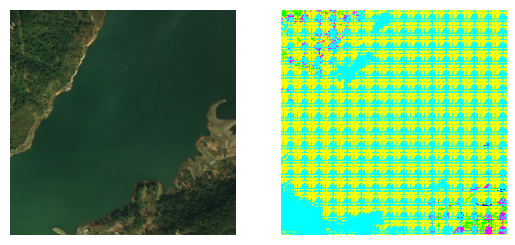

In [14]:
img = cv2.imread("E:\THIRD YEAR\Datasets\deepglobe/test/119896_sat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch).squeeze()

_, predicted_labels = torch.max(output, 0)
predicted_mask = predicted_labels.squeeze().cpu().numpy()
print(torch.unique(predicted_labels))

label_map_colors = {0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for label, color in label_map_colors.items():
    colored_mask[predicted_mask == label] = color

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored_mask)
plt.axis('off')

plt.show()

In [19]:
# mask_transform = transforms.Compose([
#     transforms.ToPILImage(),           # Convert numpy array to PIL Image
#     transforms.Resize((256, 256)),     # Resize masks
#     transforms.ToTensor(),             # Convert mask to tensor
#     transforms.Lambda(lambda x: x.long())  # Ensure mask values are integers
# ])

In [ ]:
print(f"Converted True Labels (class indices): {all_labels}")


In [28]:
# # Old version
# from sklearn.metrics import confusion_matrix
# import seaborn as sns


# # Define the function to get predictions and labels from the dataloader
# def get_predictions_and_labels(dataloader, model, device, rgb_to_class):
#     model.eval()
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
            
#             # Get predictions
#             _, preds = torch.max(outputs, 1)
            
#             # Convert RGB true labels to class indices using the reverse map
#             labels_np = labels.cpu().numpy()
#             labels_class = np.array([rgb_to_class[tuple(rgb)] for rgb in labels_np.reshape(-1, 3)])
            
#             # Store predictions and true labels (which are now class indices)
#             all_preds.extend(preds.cpu().numpy().flatten())
#             all_labels.extend(labels_class.flatten())
    
#     return np.array(all_preds), np.array(all_labels)

# print(f"Converted True Labels (class indices): {all_labels}")



# # Define the function to plot the confusion matrix
# def plot_confusion_matrix(cm, labels):
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()

# # Ensure you have a validation dataset
# valid_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)
# valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False)

# # Get predictions and true labels
# predictions, true_labels = get_predictions_and_labels(valid_dataloader, model, device)

# # Compute confusion matrix
# num_classes = len(label_map)
# cm = confusion_matrix(true_labels, predictions, labels=list(range(num_classes)))

# # Plot confusion matrix
# plot_confusion_matrix(cm, labels=list(range(num_classes)))


Number of images: 803
Number of masks: 803


ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

Number of images: 803
Number of masks: 803
Label range: 0 to 4
Prediction range: 0 to 5
Label range: 0 to 3
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 4
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 4
Prediction range: 0 to 5
Label range: 0 to 4
Prediction range: 0 to 4
Label range: 0 to 6
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 4
Prediction range: 0 to 4
Label range: 0 to 4
Prediction range: 0 to 5
Label range:

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



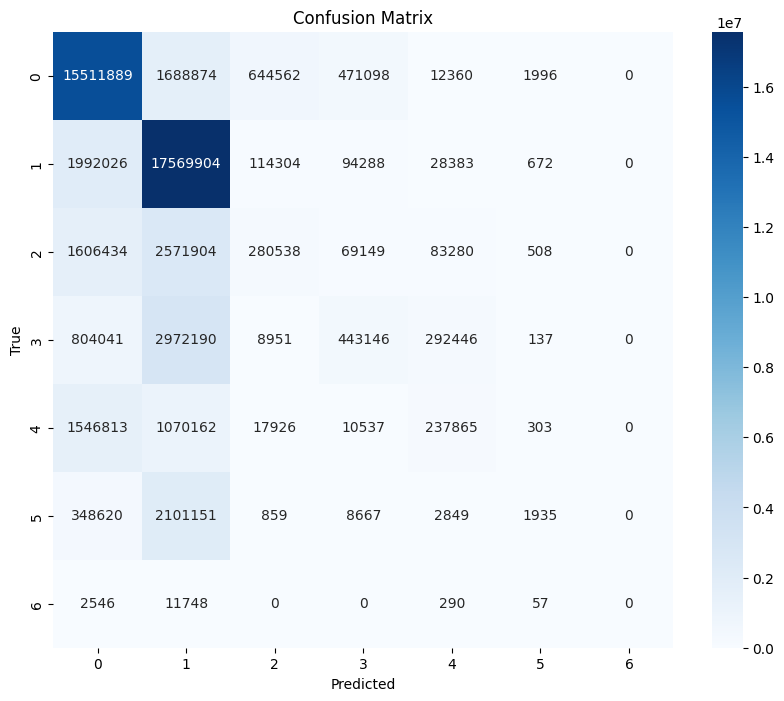

In [15]:
# Current version

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create reverse label_map to map RGB values to class indices
rgb_to_class = {tuple(value): key for key, value in label_map.items()}

# Define the function to get predictions and labels from the dataloader
def get_predictions_and_labels(dataloader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Convert single-channel true labels to class indices
            labels_np = labels.cpu().numpy().astype(np.int64)  # Convert to int for consistency
            preds_np = preds.cpu().numpy()

            # Debug: Print the range of true labels and predictions
            print(f"Label range: {labels_np.min()} to {labels_np.max()}")
            print(f"Prediction range: {preds_np.min()} to {preds_np.max()}")
            
            # Flatten arrays to simplify confusion matrix computation
            all_preds.extend(preds_np.flatten())
            all_labels.extend(labels_np.flatten())
    
    print(f"True Labels (class indices): {all_labels}")  # Debugging
    return np.array(all_preds), np.array(all_labels)

# Define the function to plot the confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Ensure you have a validation dataset (use the correct directory)
valid_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)  # Use VALID_DIR for validation
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False)

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(valid_dataloader, model, device)

# Compute confusion matrix
num_classes = len(label_map)
cm = confusion_matrix(true_labels, predictions, labels=list(range(num_classes)))

# Plot confusion matrix
plot_confusion_matrix(cm, labels=list(range(num_classes)))